In [77]:
import numpy as np
import matplotlib.pyplot as plt

class lattice(): #class that describes a crystal lattice , from Dr Alberto's lattice_utils.py file
    
    def __init__(self,a, b , c , alpha = 90 , beta = 90 , gamma = 90): # a,b,c lattice parameters in armstrong; alpha , beta , gamma in degrees 
        
        self.a = a
        self.b = b 
        self.c = c
        self.alpha = alpha*np.pi/180
        self.beta = beta*np.pi/180
        self.gamma = gamma*np.pi/180
        
        self.lvec = [a,b,c,self.alpha , self.beta,self.gamma] #lattice vector array
        
        self.gtensor()

    def gtensor(self): #function that calculates g tensor of a lattice from Dr Alberto's lattice_utils.py file
        
        g = np.empty([3,3])
        
        g[0,0] = self.a**2
        g[0,1] = self.a*self.b*np.cos(self.gamma)
        g[0,2] = self.a*self.c*np.cos(self.beta)
        
        g[1,0] = g[0,1]
        g[1,1] = self.b**2
        g[1,2] = self.c*self.b*np.cos(self.alpha)
        
        g[2,0] = g[0,2] 
        g[2,1] = g[1,2]
        g[2,2] = self.c**2
        
        self.gtensor = g
        
    def recip_lattice(self): 
        
        '''
        function by Dr Alberto that calculates the reciprocal of a lattice 
        '''
        
        a_vect = np.array([self.a,0,0])
        b_vect = np.array([self.b*np.cos(self.gamma) ,self.b*np.sin(self.gamma) ,0])
        c_vect = np.array([self.c*np.cos(self.alpha) , self.c*np.sin(self.beta) , np.sqrt(self.c**2*(1-(np.cos(self.alpha))**2 + (np.cos(self.beta)**2)))])
        
        vol = np.sum(a_vect*np.cross(b_vect , c_vect))
        
        a_star = 2*np.pi*self.b*self.c*np.sin(self.alpha)/vol
        b_star = 2*np.pi*self.a*self.c*np.sin(self.beta)/vol
        c_star = 2*np.pi*self.a*self.b*np.sin(self.gamma)/vol
        
        alpha_star = np.arccos((np.cos(self.beta)*np.cos(self.gamma)-np.cos(self.alpha))/(np.sin(self.beta)*np.sin(self.gamma)))
        beta_star = np.arccos((np.cos(self.alpha)*np.cos(self.gamma)-np.cos(self.beta))/(np.sin(self.alpha)*np.sin(self.gamma)))
        gamma_star = np.arccos((np.cos(self.alpha)*np.cos(self.beta)-np.cos(self.gamma))/(np.sin(self.alpha)*np.sin(self.beta)))
        
        alpha_new = np.rad2deg(alpha_star)
        beta_new = np.rad2deg(beta_star)
        gamma_new = np.rad2deg(gamma_star)
        
        self.rlatt = lattice(a_star , b_star , c_star , alpha_new , beta_new , gamma_new)
        


        

In [78]:
        
class VectorOps(): #class with methods for vector operations
    
    @staticmethod
    def vector(v1 , v2 , latt): 
        
        '''
        function by Dr Alberto that calculates prodct of two vectors given by its miller indice
        '''
        
        u = (v1[1]*v2[2] - v2[1]*v1[2])
        v = (v1[2]*v2[0] - v2[2]*v1[0])
        w = (v1[0]*v2[1] - v2[0]*v1[1])

        new_vector = Miller([u,v,w] , latt)

        return new_vector
    
    @staticmethod
    def Miller(V,latt):
        
        '''
        function by Dr Alberto that calculates miller indice of a vector 
        '''
        
        g = latt.gtensor
        
        h = (g[0,0]*V[0] + g[1,0]*V[1] + g[2,0]*V[2])/(2.*np.pi)
        k = (g[0,1]*V[0] + g[1,1]*V[1] + g[2,1]*V[2])/(2.*np.pi)
        l = (g[0,2]*V[0] + g[1,2]*V[1] + g[2,2]*V[2])/(2.*np.pi)
        
        return [h,k,l]
    
        
    @staticmethod
    def scalar(v1 , v2 , latt):
        
        '''
        function by Dr Alberto that calculates the scalar product of 2 vectors given by its miller indice
        '''
        
        s1 = v1[0]*v2[0]*latt.a**2 + v1[1]*v2[1]*latt.b*2 + v1[2]*v2[2]*latt.c**2
        s2 = (v1[0]*v2[1] + v2[0]*v1[1])*latt.a*latt.b*np.cos(latt.gamma)
        s3 = (v1[0]*v2[2] + v1[2]*v2[0])*latt.a*latt.c*np.cos(latt.beta)
        s4 = (v1[1]*v2[2] + v2[2]*v1[1])*latt.c*latt.b*np.cos(latt.alpha)
        
        s = s1+s2+s3+s3
        
        return s
    
    @staticmethod
    def modVec(v1 , latt):
        
        '''
        function by Dr Alberto that calculates magnitude of a vector given by its miller indice
        '''
        
        mod = np.sqrt(VectorOps.scalar(v1 , v1 , latt))
        
        return mod
    
    @staticmethod
    def dspacing(v1 , r_latt):
        
        '''
        function by Dr Alberto that calculates d spacing to a given set of miller indices arguments
        '''
        
        d = 2*np.pi/VectorOps.modVec(v1,r_latt)
        
        return d

In [79]:
class PowderDiffraction():
    
    def __init__(self ,latt:lattice,wavelength,type_,atomic_scattering_factors:list):
        
        self.latt = latt
        self.FCC_PEAKS =[[1,1,1],[2,0,0],[2,2,0],[3,1,1],[2,2,2],[4,0,0],[3,3,1],[4,2,0],
            [4,2,2],[5,1,1],[3,3,3],[4,4,0],[5,3,1],[4,4,2],[6,0,0]]
    
        self.FCC_M_FACTORS = [8,6,12,24,8]
        self.type_ = type_
        self.tth2_list = []
        self.modQ = []
        self.h = []
        self.k = []
        self.l = []
        self.wavelength = wavelength
        self.I_list = []
        self.ASF = atomic_scattering_factors
        self.F_list = []
        
    def Calculate(self):
        
        self.FindPeaks()
        
        for peak in self.peaks:
            
            self.modQ.append(VectorOps.modVec(peak , self.latt))
            current_disp = VectorOps.dspacing(peak , self.latt)
            
            tth2 = (360/np.pi)*np.arcsin((self.wavelength/2)/(2*current_disp))
            
            asf = self.CalculateASF(tth2/2)
            
            f = PowderDiffraction.CalculateF(peak , asf)
            
            self.F_list.append(f)
            
            I = PowderDiffraction.CalculateIntensity(peak , tth2 , asf )
            
            #print(asf)
            
            self.tth2_list.append(tth2)
            self.I_list.append(I)
            self.h.append(peak[0])
            self.k.append(peak[1])
            self.l.append(peak[2])
        
        max_i = max(self.I_list)
        
        self.RI_list = []
        
        for i in self.I_list:
            
            self.RI_list.append((i/max_i)*100)
        
        al_diff.tth2_list.sort()
    
    @staticmethod
    def CalculateF(peak , asf):
        
        h,k,l = peak[0] , peak[1] , peak[2]
        
        if h%2!=k%2!=l%2:
            
            return 0 
        
        return 4*asf
    
    
    def CalculateASF(self,theta):
        
        index = round(np.sin(theta)/self.wavelength)
        
        if index > 10:
            
            index = 10
        
        return self.ASF[int(index)]
    
    @staticmethod
    def CalculateIntensity(peak , tth2,  asf):
        
        f = PowderDiffraction.CalculateF(peak ,asf)
        
        I = f**2
        
        return I
        
    def FindPeaks(self):
        
        if self.type_ == 0:
            
            self.peaks = self.FCC_PEAKS
            self.m_factor = self.FCC_M_FACTORS
        
        
        
        
    

1   1   1    52    12.85607709499695    100.0
2   0   0    44.92    14.183996212044145    74.6230177514793
2   2   0    9.32    21.53174342610014    3.2123668639053258
3   1   1    9.32    23.94157814261173    3.2123668639053258
2   2   2    52    25.877636094593893    100.0
4   0   0    44.92    28.591339205910682    74.6230177514793
3   3   1    9.32    32.99102553458802    3.2123668639053258
4   2   0    9.32    33.34657432701642    3.2123668639053258
4   2   2    9.32    36.07278093696288    3.2123668639053258
5   1   1    52    37.625779388642286    100.0
3   3   3    44.92    39.2503788736533    74.6230177514793
4   4   0    52    43.47917803156205    100.0
5   3   1    52    43.87467781514645    100.0
4   4   2    9.32    44.486455429075384    3.2123668639053258
6   0   0    52    46.34049034329338    100.0


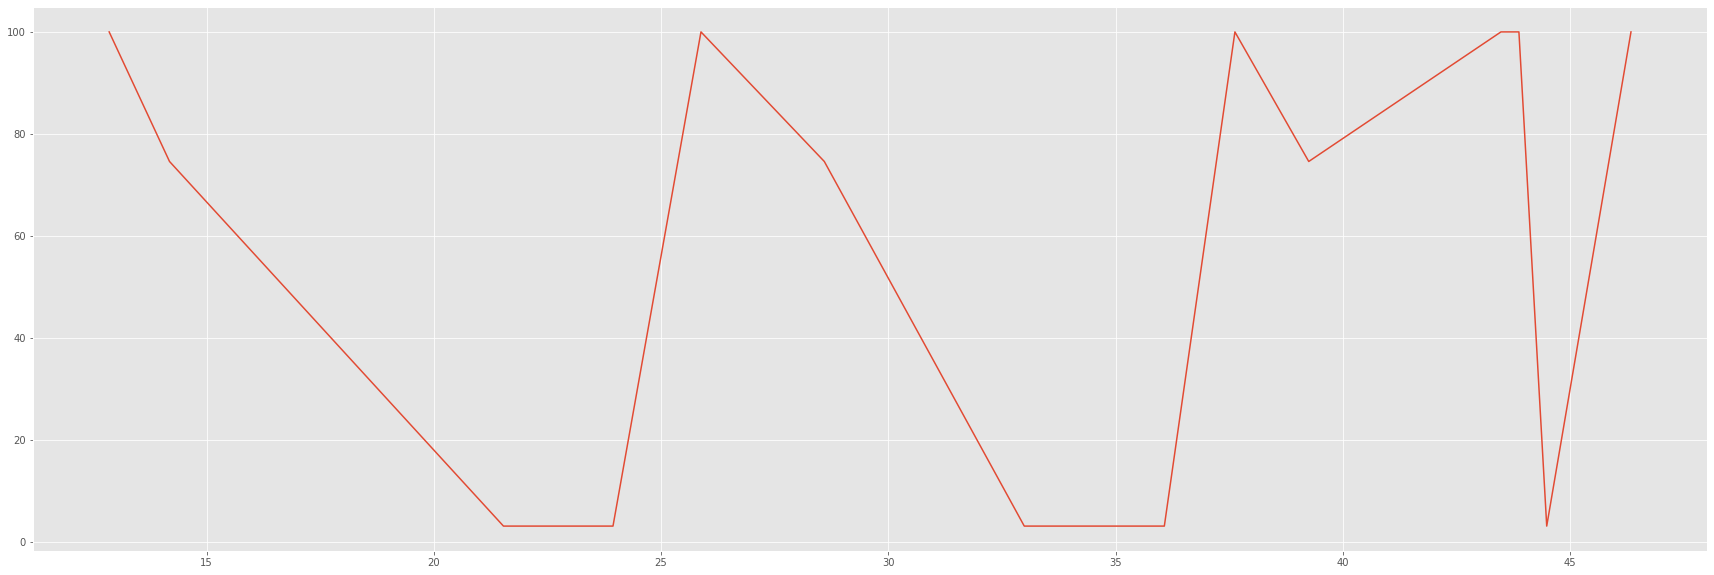

In [81]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.figure(figsize=(30,10))

al_asf_list = [13,11.23,9.158,7.873,6.766,5.692,4.713,3.883,3.221,2.712,2.330]

al_lattice = lattice(4.0498,4.0498,4.0498)
al_lattice.recip_lattice()
al_diff = PowderDiffraction(al_lattice.rlatt ,1, 0,al_asf_list)
al_diff.Calculate()

for i in range(len(al_diff.peaks)):
    
    peak = al_diff.peaks[i]
    h,k,l,f,I = peak[0],peak[1],peak[2],al_diff.F_list[i], al_diff.RI_list[i]
    print("{}   {}   {}    {}    {}    {}".format(h,k,l,f,al_diff.tth2_list[i],I))

plt.plot(al_diff.tth2_list , al_diff.RI_list)
